In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from ISLP import load_data

In [2]:
from sklearn.cluster import (KMeans, AgglomerativeClustering)
from scipy.cluster.hierarchy import dendrogram, cut_tree
from ISLP.cluster import compute_linkage

In [3]:
USArrests = get_rdataset("USArrests").data
USArrests.head()

,Murder,Assault,UrbanPop,Rape
rownames,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [4]:
USArrests.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [5]:
USArrests.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

In [6]:
USArrests.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

In [7]:
scaler = StandardScaler(with_std=True, with_mean=True)
USArrests_scaled = scaler.fit_transform(USArrests)

In [8]:
pcaUS = PCA()

In [9]:
pcaUS.fit(USArrests_scaled)

PCA()

In [10]:
pcaUS.mean_

array([-7.10542736e-17,  1.38777878e-16, -4.39648318e-16,  8.59312621e-16])

In [11]:
scores = pcaUS.transform(USArrests_scaled)

In [12]:
pcaUS.components_

array([[ 0.53589947,  0.58318363,  0.27819087,  0.54343209],
       [-0.41818087, -0.1879856 ,  0.87280619,  0.16731864],
       [-0.34123273, -0.26814843, -0.37801579,  0.81777791],
       [-0.6492278 ,  0.74340748, -0.13387773, -0.08902432]])

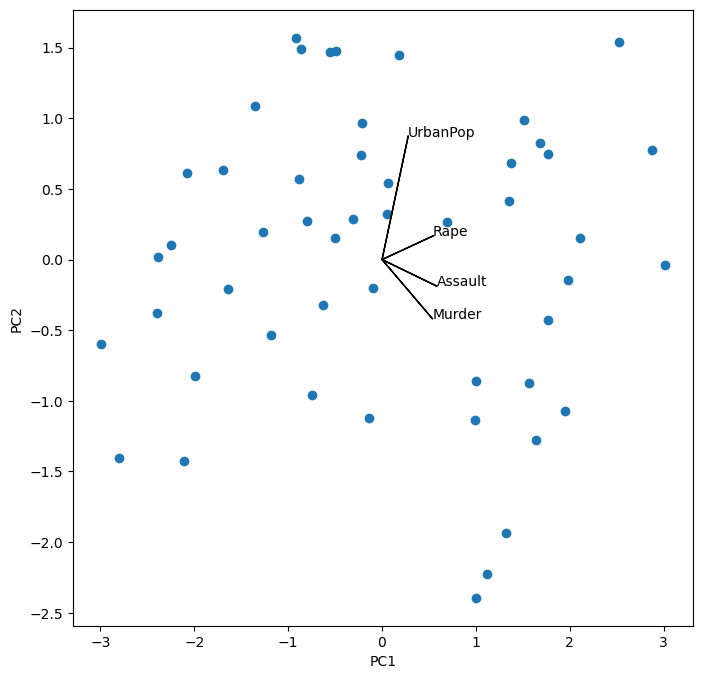

In [13]:
i, j = 0, 1
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(scores[:, 0], scores[:, 1])
ax.set_xlabel("PC%d" % (i + 1))
ax.set_ylabel("PC%d" % (j + 1))
for k in range(pcaUS.components_.shape[1]):
    ax.arrow(0, 0, pcaUS.components_[i, k], pcaUS.components_[j, k])
    ax.text(pcaUS.components_[i, k],
            pcaUS.components_[j, k],
            USArrests.columns[k])


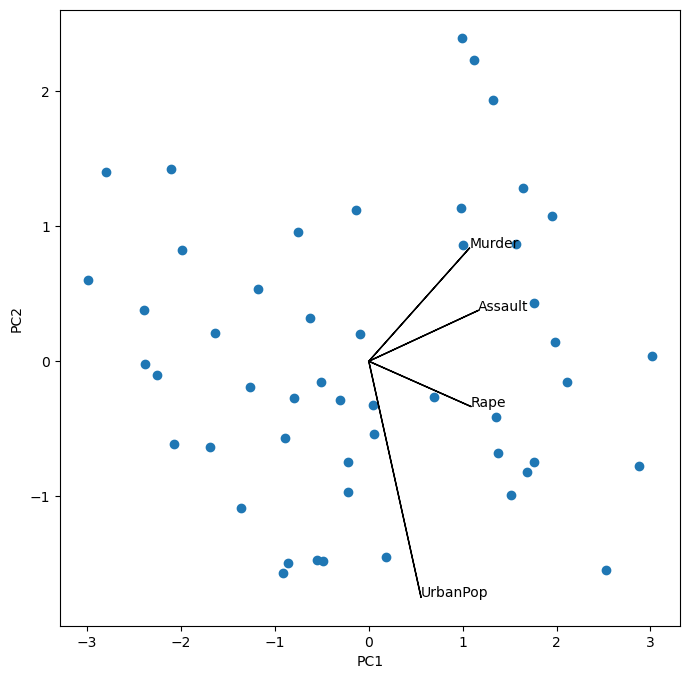

In [14]:
scale_arrow = s_ = 2
scores [:,1] *= -1
pcaUS.components_ [1] *= -1 # flip the y-axis
fig , ax = plt.subplots (1, 1, figsize =(8, 8))
ax.scatter(scores [:,0], scores [: ,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pcaUS.components_.shape [1]):
    ax.arrow(0, 0, s_*pcaUS.components_[i,k], s_*pcaUS.components_[j,k])
    ax.text(s_*pcaUS.components_[i,k],
    s_*pcaUS.components_[j,k],
    USArrests.columns[k])

In [15]:
scores.std(0, ddof=1)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [16]:
pcaUS.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [17]:
pcaUS.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

In [18]:
%%capture
fig , axes = plt.subplots (1, 2, figsize =(15, 6))
ticks = np.arange(pcaUS.n_components_)+1
ax = axes [0]
ax.plot(ticks ,
        pcaUS.explained_variance_ratio_ ,
        marker='o')
ax.set_xlabel('Principal Component ');
ax.set_ylabel('Proportion of Variance Explained ')
ax.set_ylim ([0 ,1])
ax.set_xticks(ticks)

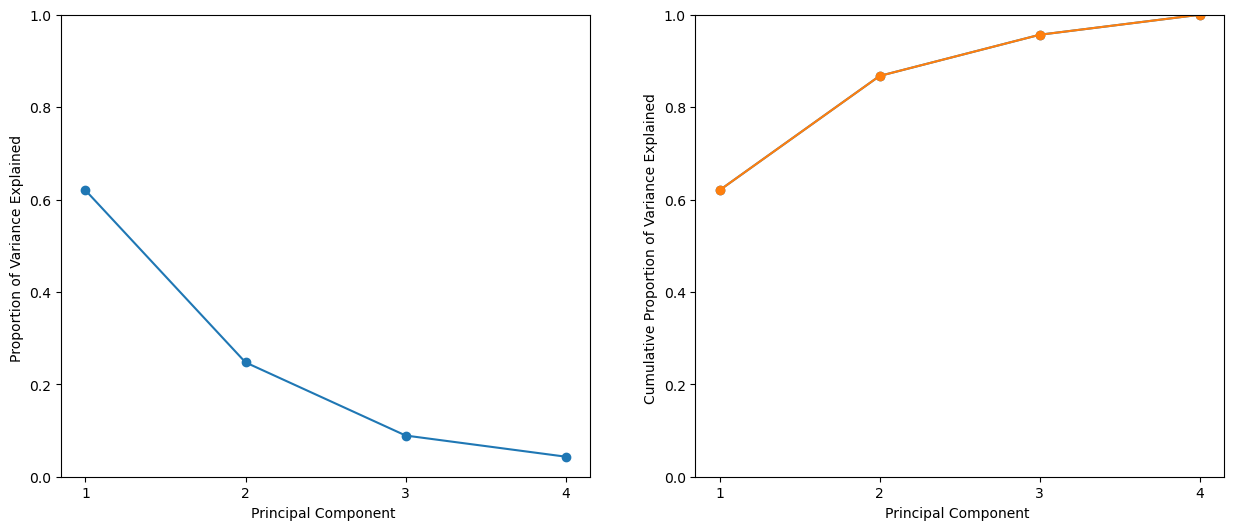

In [20]:
ax = axes[1]
ax.plot(ticks ,
pcaUS. explained_variance_ratio_ .cumsum(),
marker='o')
ax.set_xlabel('Principal Component ')
ax.set_ylabel('Cumulative Proportion of Variance Explained ')
ax.set_ylim ([0, 1])
ax.set_xticks(ticks)
fig

In [21]:
a = np.array([1, 2, 8, -3])
np.cumsum(a)

array([ 1,  3, 11,  8])

In [22]:
X = USArrests_scaled
U, D, V = np.linalg.svd(X, full_matrices=False)
U.shape, D.shape, V.shape

((50, 4), (4,), (4, 4))

In [23]:
n_omit = 20
np.random.seed(15)
r_idx = np.random.choice(np.arange(X.shape[0]),
                         n_omit,
                         replace=False)
c_idx = np.random.choice(np.arange(X.shape[1]),
                         n_omit,
                         replace=True)
Xna = X.copy()
Xna[r_idx, c_idx] = np.nan

In [24]:
def low_rank(X, M=1):
    U, D, V = np.linalg.svd(X)
    L = U[:,:M] * D[None,:M]
    return L.dot(V[:M])

In [25]:
Xhat = Xna.copy()
Xbar = np.nanmean(Xhat, axis=0)
Xhat[r_idx, c_idx] = Xbar[c_idx]

In [26]:
thresh = 1e-7
rel_err = 1
count = 0
ismiss = np.isnan(Xna)
mssold = np.mean(Xhat[~ismiss]**2)
mss0 = np.mean(Xna[~ismiss]**2)

In [27]:
while rel_err > thresh:
    count += 1
    # Step 2(a)
    Xapp = low_rank(Xhat, M=1)
    # Step 2(b)
    Xhat[ismiss] = Xapp[ismiss]
    # Step 2(c)
    mss = np.mean(((Xna - Xapp)[~ismiss])**2)
    rel_err = (mssold - mss) / mss0
    mssold = mss
    print("Iteration: {0}, MSS:{1:.3f}, Rel.Err {2:.2e}"
          .format(count, mss, rel_err))

Iteration: 1, MSS:0.395, Rel.Err 5.99e-01
Iteration: 2, MSS:0.382, Rel.Err 1.33e-02
Iteration: 3, MSS:0.381, Rel.Err 1.44e-03
Iteration: 4, MSS:0.381, Rel.Err 1.79e-04
Iteration: 5, MSS:0.381, Rel.Err 2.58e-05
Iteration: 6, MSS:0.381, Rel.Err 4.22e-06
Iteration: 7, MSS:0.381, Rel.Err 7.65e-07
Iteration: 8, MSS:0.381, Rel.Err 1.48e-07
Iteration: 9, MSS:0.381, Rel.Err 2.95e-08


In [29]:
np.random.seed(0);
X = np.random.standard_normal((50,2));
X[:25,0] += 3
X[:25,1] -= 4

In [31]:
kmeans = KMeans(n_clusters=2,
                random_state=2,
                n_init=20).fit(X)

In [32]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1], dtype=int32)

Text(0.5, 1.0, 'K-Means')

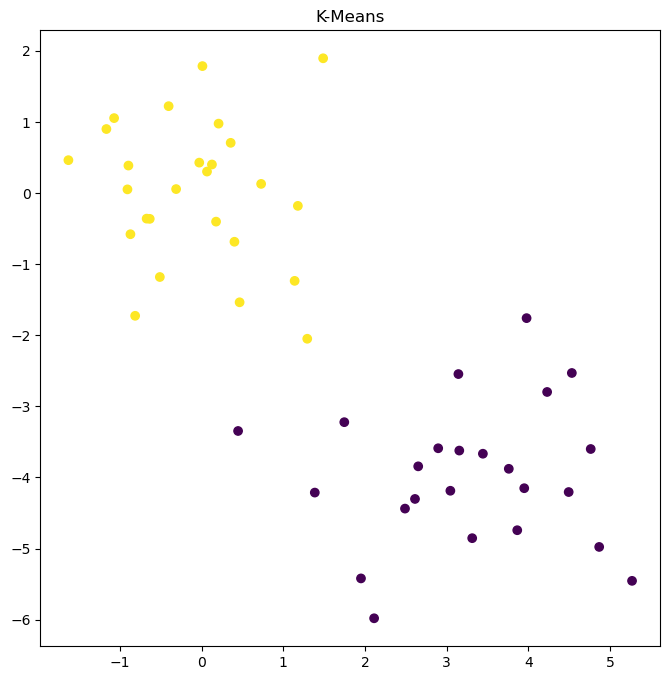

In [33]:
fig, ax = plt.subplots(1 ,1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
ax.set_title("K-Means")

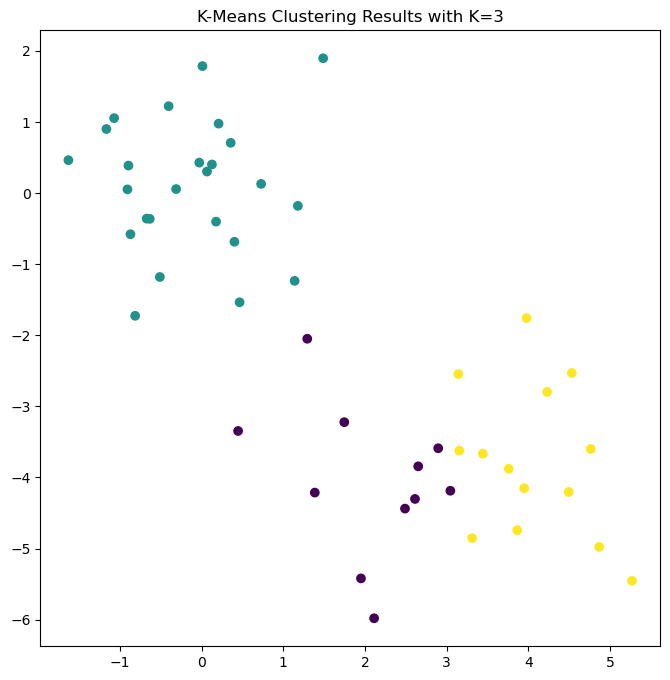

In [34]:
kmeans = KMeans(n_clusters=3,
                random_state=3,
                n_init=20).fit(X)
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(X[:,0], X[:,1], c=kmeans.labels_)
ax.set_title("K-Means Clustering Results with K=3");

In [38]:
HClust = AgglomerativeClustering
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='complete')
hc_comp.fit(X)

AgglomerativeClustering(distance_threshold=0, linkage='complete',
                        n_clusters=None)

In [40]:
hc_avg = HClust(distance_threshold=0,
                n_clusters=None,
                linkage='average');
hc_avg.fit(X)
hc_sing = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='single');
hc_sing.fit(X);

In [41]:
D = np.zeros((X.shape[0], X.shape[0]));
for i in range(X.shape[0]):
    x_ = np.multiply.outer(np.ones(X.shape[0]), X[i])
    D[i] = np.sqrt(np.sum((X - x_)**2, 1));
hc_sing_pre = HClust(distance_threshold=0,
                     n_clusters=None,
                     metric='precomputed',
                     linkage='single')
hc_sing_pre.fit(D)

AgglomerativeClustering(distance_threshold=0, linkage='single',
                        metric='precomputed', n_clusters=None)

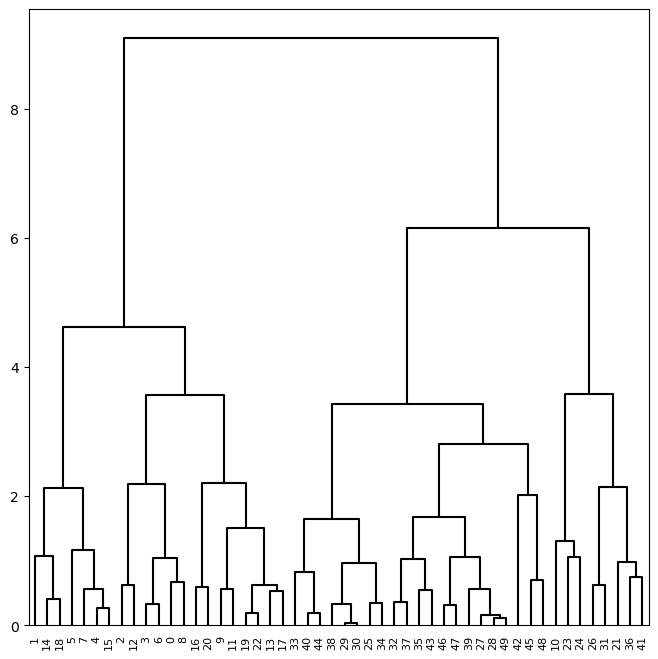

In [42]:
cargs = {'color_threshold':-np.inf,
         'above_threshold_color':'black'}
linkage_comp = compute_linkage(hc_comp)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           **cargs);

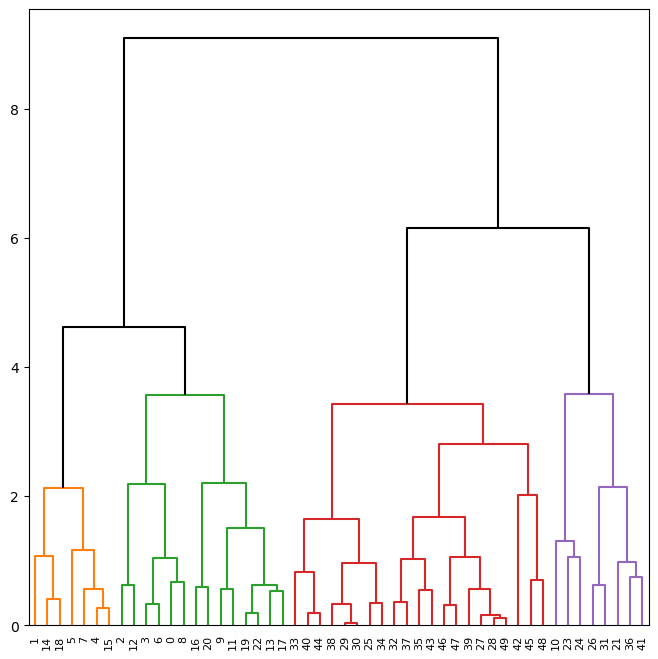

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp,
           ax=ax,
           color_threshold=4,
           above_threshold_color='black');

In [44]:
cut_tree(linkage_comp, n_clusters=4).T

array([[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 2,
        0, 2, 2, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 3, 3,
        3, 3, 3, 3, 3, 3]])

In [47]:
cut_tree(linkage_comp, height=5)

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [1],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2],
       [2]])

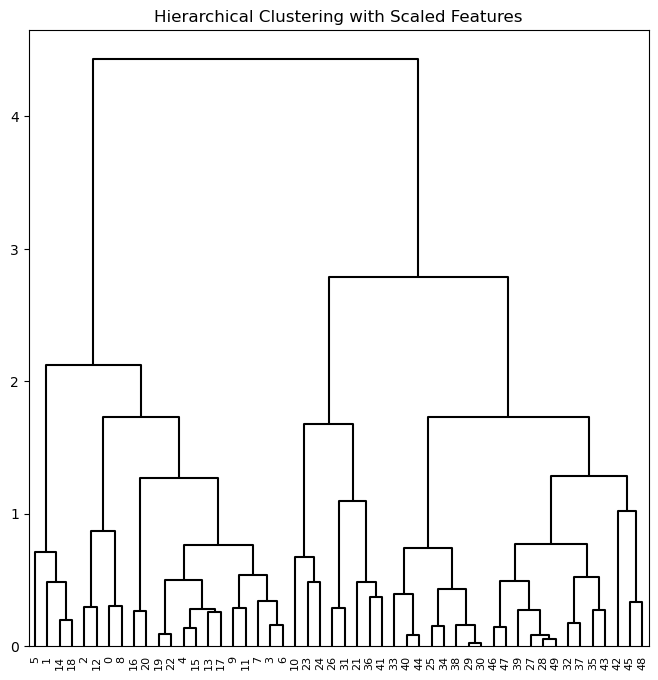

In [48]:
scaler = StandardScaler()
X_scale = scaler.fit_transform(X)
hc_comp_scale = HClust(distance_threshold=0,
                       n_clusters=None,
                       linkage='complete').fit(X_scale)
linkage_comp_scale = compute_linkage(hc_comp_scale)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_comp_scale, ax=ax, **cargs)
ax.set_title("Hierarchical Clustering with Scaled Features");

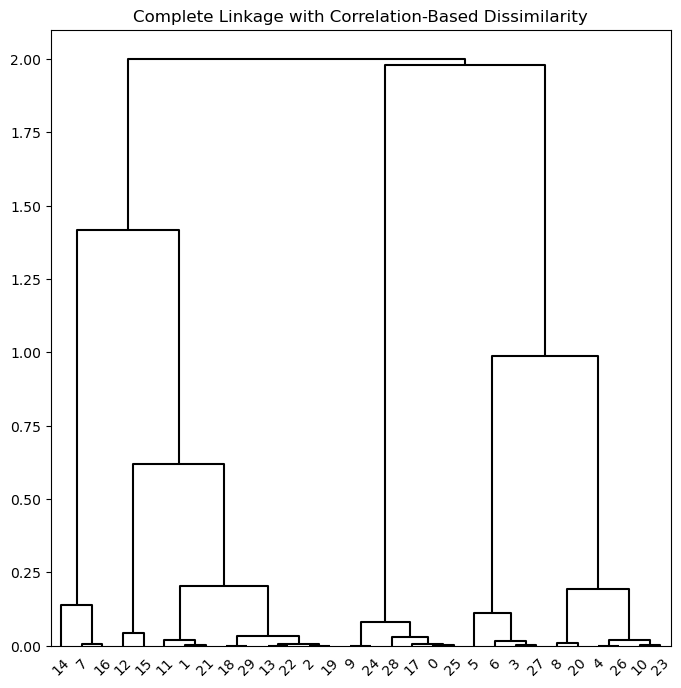

In [49]:
X = np.random.standard_normal((30, 3))
corD = 1 - np.corrcoef(X)
hc_cor = HClust(linkage='complete',
                distance_threshold=0,
                n_clusters=None,
                metric='precomputed')
hc_cor.fit(corD)
linkage_cor = compute_linkage(hc_cor)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
dendrogram(linkage_cor, ax=ax, **cargs)
ax.set_title("Complete Linkage with Correlation-Based Dissimilarity");

In [51]:
NCI60 = load_data("NCI60")
nci_labs = NCI60["labels"]
nci_data = NCI60["data"]

In [52]:
nci_data.shape

(64, 6830)

In [53]:
nci_labs.value_counts()

label      
RENAL          9
NSCLC          9
MELANOMA       8
BREAST         7
COLON          7
LEUKEMIA       6
OVARIAN        6
CNS            5
PROSTATE       2
K562A-repro    1
K562B-repro    1
MCF7D-repro    1
MCF7A-repro    1
UNKNOWN        1
Name: count, dtype: int64

In [54]:
scaler = StandardScaler()
nci_scaled = scaler.fit_transform(nci_data)
nci_pca = PCA()
nci_scores = nci_pca.fit_transform(nci_scaled)

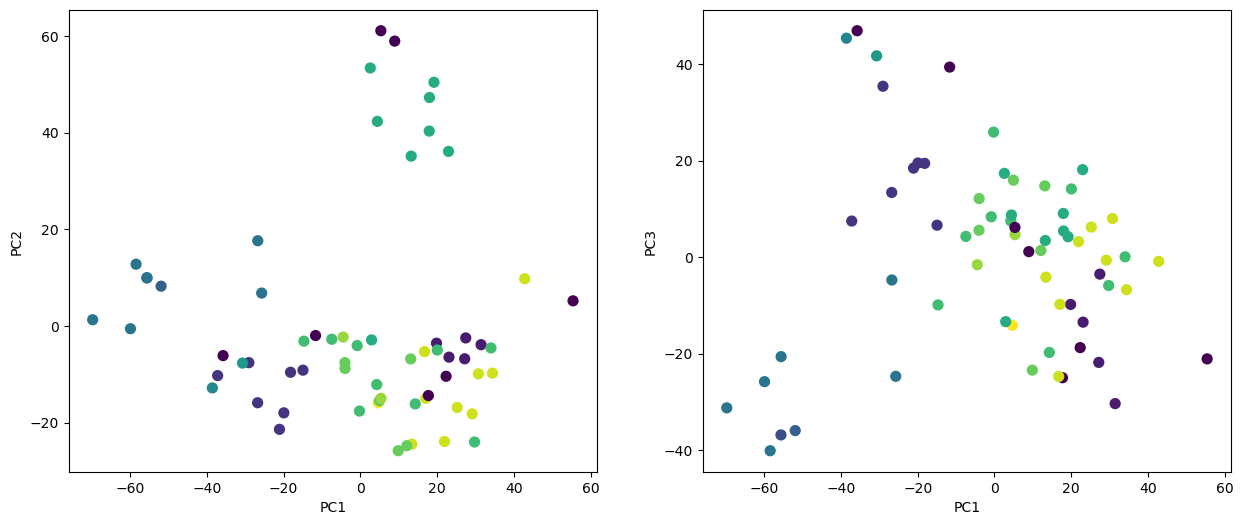

In [55]:
cancer_types = list(np.unique(nci_labs))
nci_groups = np.array([cancer_types.index(lab)
                       for lab in nci_labs.values])
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ax.scatter(nci_scores[:,0],
           nci_scores[:,1],
           c=nci_groups,
           marker='o',
           s=50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2')
ax = axes[1]
ax.scatter(nci_scores[:,0],
           nci_scores[:,2],
           c=nci_groups,
           marker='o',
           s=50)
ax.set_xlabel('PC1'); ax.set_ylabel('PC3');

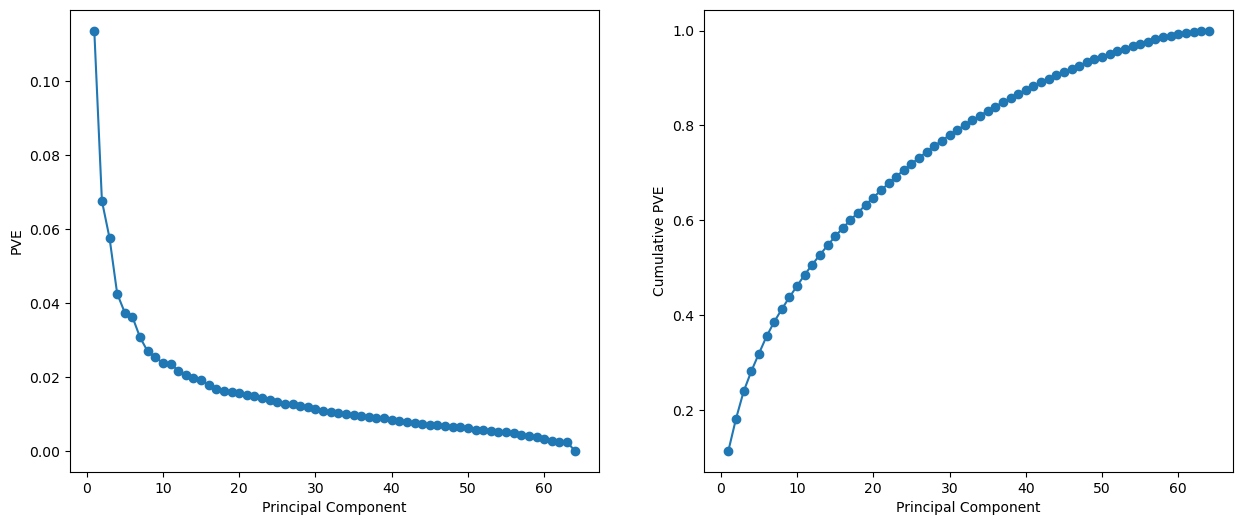

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
ax = axes[0]
ticks = np.arange(nci_pca.n_components_)+1
ax.plot(ticks,
        nci_pca.explained_variance_ratio_,
        marker='o')
ax.set_xlabel('Principal Component');
ax.set_ylabel('PVE')
ax = axes[1]
ax.plot(ticks,
        nci_pca.explained_variance_ratio_.cumsum(),
        marker='o');
ax.set_xlabel('Principal Component')
ax.set_ylabel('Cumulative PVE');

In [57]:
def plot_nci(linkage, ax, cut=-np.inf):
    cargs = {'above_threshold_color':'black',
             'color_threshold':cut}
    hc = HClust(n_clusters=None,
                distance_threshold=0,
                linkage=linkage.lower()).fit(nci_scaled)
    linkage_ = compute_linkage(hc)
    dendrogram(linkage_,
               ax=ax,
               labels=np.asarray(nci_labs),
               leaf_font_size=10,
               **cargs)
    ax.set_title('%s Linkage' % linkage)
    return hc

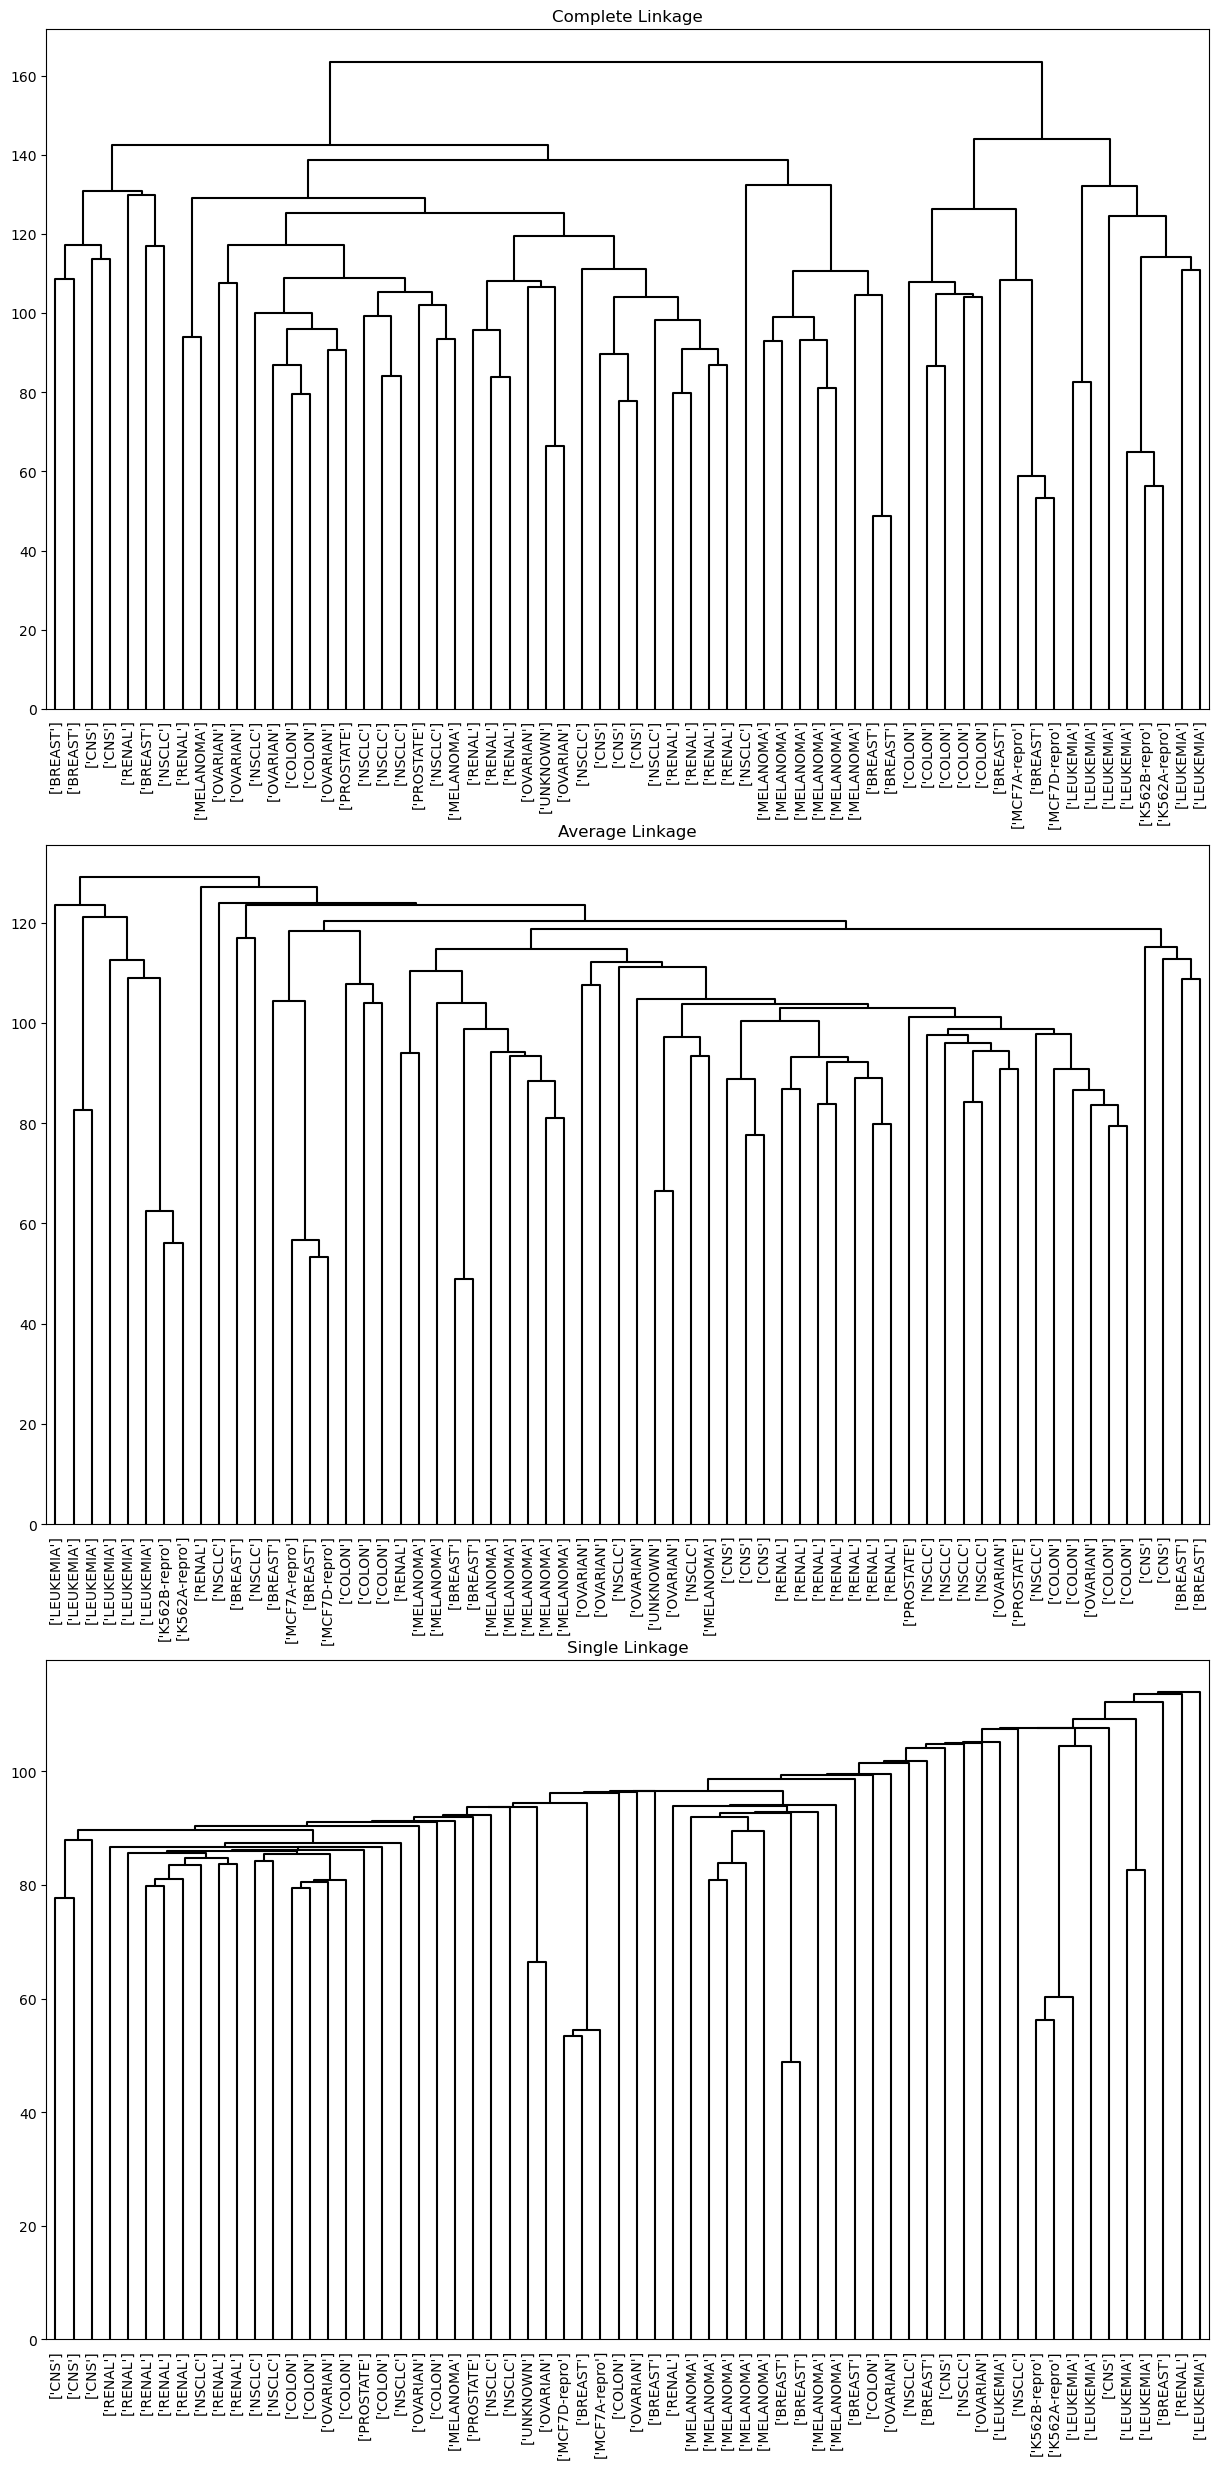

In [58]:
fig, axes = plt.subplots(3, 1, figsize=(15,30))      
ax = axes[0]; hc_comp = plot_nci('Complete', ax)
ax = axes[1]; hc_avg = plot_nci('Average', ax)
ax = axes[2]; hc_sing = plot_nci('Single', ax)

In [59]:
linkage_comp = compute_linkage(hc_comp)
comp_cut = cut_tree(linkage_comp, n_clusters=4).reshape(-1)
pd.crosstab(nci_labs['label'],
            pd.Series(comp_cut.reshape(-1), name='Complete'))

Complete,0,1,2,3
label,,,,
BREAST,2,3,0,2
CNS,3,2,0,0
COLON,2,0,0,5
K562A-repro,0,0,1,0
K562B-repro,0,0,1,0
LEUKEMIA,0,0,6,0
MCF7A-repro,0,0,0,1
MCF7D-repro,0,0,0,1
MELANOMA,8,0,0,0


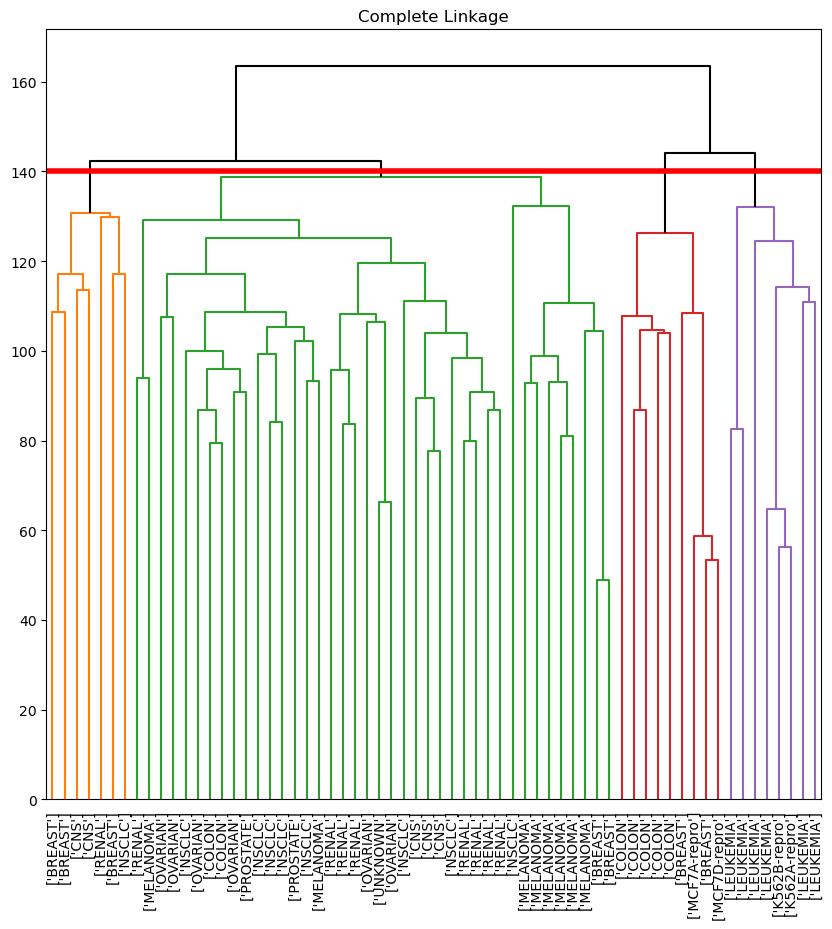

In [60]:
fig, ax = plt.subplots(figsize=(10,10))
plot_nci('Complete', ax, cut=140)
ax.axhline(140, c='r', linewidth=4);

In [61]:
nci_kmeans = KMeans(n_clusters=4, 
                    random_state=0,
                    n_init=20).fit(nci_scaled)
pd.crosstab(pd.Series(comp_cut, name='HClust'),
            pd.Series(nci_kmeans.labels_, name='K-means'))

K-means,0,1,2,3
HClust,,,,
0,1,20,10,9
1,0,7,0,0
2,8,0,0,0
3,0,0,9,0
